<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W4/ungraded_labs/C4_W4_Lab_1_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### CONV LSTM

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 29ms/step - loss: 73.1912 - mae: 73.6903
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 72.4799 - mae: 72.9791
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 71.3446 - mae: 71.8437
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 69.9230 - mae: 70.4223
Epoch 5/100
8/8 [==============================] - 0s 27ms/step - loss: 68.2678 - mae: 68.7669
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 66.3621 - mae: 66.8609
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 64.2432 - mae: 64.7424
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 61.8749 - mae: 62.3738
Epoch 9/100
8/8 [==============================] - 0s 27ms/step - loss: 59.2491 - mae: 59.7479
Epoch 10/100
8/8 [==============================] - 0s 27ms/step - loss: 56.3267 - mae: 56.8254
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 28ms/step - loss: 14.8753 - mae: 15.3689
Epoch 88/100
8/8 [==============================] - 0s 27ms/step - loss: 12.9814 - mae: 13.4729
Epoch 89/100
8/8 [==============================] - 0s 27ms/step - loss: 22.1579 - mae: 22.6549
Epoch 90/100
8/8 [==============================] - 0s 27ms/step - loss: 15.2303 - mae: 15.7236
Epoch 91/100
8/8 [==============================] - 0s 28ms/step - loss: 12.5978 - mae: 13.0908
Epoch 92/100
8/8 [==============================] - 0s 30ms/step - loss: 14.4217 - mae: 14.9150
Epoch 93/100
8/8 [==============================] - 0s 29ms/step - loss: 23.9998 - mae: 24.4954
Epoch 94/100
8/8 [==============================] - 0s 29ms/step - loss: 18.2359 - mae: 18.7298
Epoch 95/100
8/8 [==============================] - 0s 27ms/step - loss: 18.0411 - mae: 18.5365
Epoch 96/100
8/8 [==============================] - 0s 28ms/step - loss: 24.4033 - mae: 24.8992
Epoch 97/100
8/8 [==============================] - 0

[1e-08, 0.0001, 0, 30]

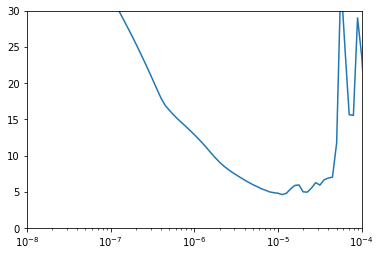

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 3s 12ms/step - loss: 20.0714 - mae: 20.5646
Epoch 2/500
31/31 [==============================] - 0s 13ms/step - loss: 7.9198 - mae: 8.4048
Epoch 3/500
31/31 [==============================] - 0s 12ms/step - loss: 6.6716 - mae: 7.1533
Epoch 4/500
31/31 [==============================] - 0s 12ms/step - loss: 6.1672 - mae: 6.6477
Epoch 5/500
31/31 [==============================] - 0s 12ms/step - loss: 5.7153 - mae: 6.1948
Epoch 6/500
31/31 [==============================] - 0s 12ms/step - loss: 5.6793 - mae: 6.1597
Epoch 7/500
31/31 [==============================] - 0s 12ms/step - loss: 5.4935 - mae: 5.9721
Epoch 8/500
31/31 [==============================] - 0s 12ms/step - loss: 5.3494 - mae: 5.8288
Epoch 9/500
31/31 [==============================] - 0s 12ms/step - loss: 5.2900 - mae: 5.7696
Epoch 10/500
31/31 [==============================] - 0s 12ms/step - loss: 5.2240 - mae: 5.7039
Epoch 11/500
31/31 [===========================

31/31 [==============================] - 0s 12ms/step - loss: 4.3780 - mae: 4.8544
Epoch 86/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2721 - mae: 4.7468
Epoch 87/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2954 - mae: 4.7710
Epoch 88/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2209 - mae: 4.6951
Epoch 89/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2228 - mae: 4.6975
Epoch 90/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2343 - mae: 4.7088
Epoch 91/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2420 - mae: 4.7163
Epoch 92/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2434 - mae: 4.7184
Epoch 93/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2169 - mae: 4.6911
Epoch 94/500
31/31 [==============================] - 0s 12ms/step - loss: 4.2966 - mae: 4.7707
Epoch 95/500
31/31 [==============================] -

31/31 [==============================] - 0s 12ms/step - loss: 4.1133 - mae: 4.5870
Epoch 170/500
31/31 [==============================] - 0s 13ms/step - loss: 4.2689 - mae: 4.7439
Epoch 171/500
31/31 [==============================] - 0s 12ms/step - loss: 4.1010 - mae: 4.5742
Epoch 172/500
31/31 [==============================] - 0s 12ms/step - loss: 4.1389 - mae: 4.6126
Epoch 173/500
31/31 [==============================] - 0s 12ms/step - loss: 4.1101 - mae: 4.5833
Epoch 174/500
31/31 [==============================] - 1s 15ms/step - loss: 4.1116 - mae: 4.5850
Epoch 175/500
31/31 [==============================] - 0s 12ms/step - loss: 4.1493 - mae: 4.6239
Epoch 176/500
31/31 [==============================] - 0s 13ms/step - loss: 4.1085 - mae: 4.5810
Epoch 177/500
31/31 [==============================] - 0s 13ms/step - loss: 4.1110 - mae: 4.5844
Epoch 178/500
31/31 [==============================] - 0s 12ms/step - loss: 4.1313 - mae: 4.6056
Epoch 179/500
31/31 [=======================

Epoch 253/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0390 - mae: 4.5116
Epoch 254/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0292 - mae: 4.5020
Epoch 255/500
31/31 [==============================] - 0s 13ms/step - loss: 4.1264 - mae: 4.6007
Epoch 256/500
31/31 [==============================] - 0s 13ms/step - loss: 4.1305 - mae: 4.6042
Epoch 257/500
31/31 [==============================] - 0s 13ms/step - loss: 4.1446 - mae: 4.6183
Epoch 258/500
31/31 [==============================] - 0s 13ms/step - loss: 4.0653 - mae: 4.5378
Epoch 259/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0360 - mae: 4.5092
Epoch 260/500
31/31 [==============================] - 0s 14ms/step - loss: 4.0876 - mae: 4.5604
Epoch 261/500
31/31 [==============================] - 0s 12ms/step - loss: 4.1390 - mae: 4.6132
Epoch 262/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0763 - mae: 4.5499
Epoch 263/500
31/31 [=========

31/31 [==============================] - 0s 12ms/step - loss: 4.0667 - mae: 4.5406
Epoch 338/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9820 - mae: 4.4545
Epoch 339/500
31/31 [==============================] - 0s 14ms/step - loss: 3.9602 - mae: 4.4320
Epoch 340/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0376 - mae: 4.5106
Epoch 341/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0389 - mae: 4.5131
Epoch 342/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0017 - mae: 4.4742
Epoch 343/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9825 - mae: 4.4549
Epoch 344/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0140 - mae: 4.4873: 0s - loss: 4.0161 - mae: 4.489
Epoch 345/500
31/31 [==============================] - 0s 12ms/step - loss: 4.0021 - mae: 4.4752
Epoch 346/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9687 - mae: 4.4404
Epoch 347/50

31/31 [==============================] - 0s 12ms/step - loss: 3.9479 - mae: 4.4197
Epoch 421/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9264 - mae: 4.3975: 0s - loss: 3.9394 - mae: 4.4
Epoch 422/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9301 - mae: 4.4016
Epoch 423/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9273 - mae: 4.3984
Epoch 424/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9336 - mae: 4.4055
Epoch 425/500
31/31 [==============================] - 1s 14ms/step - loss: 3.9571 - mae: 4.4294
Epoch 426/500
31/31 [==============================] - 0s 13ms/step - loss: 3.9463 - mae: 4.4181
Epoch 427/500
31/31 [==============================] - 0s 13ms/step - loss: 3.9754 - mae: 4.4480
Epoch 428/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9487 - mae: 4.4205
Epoch 429/500
31/31 [==============================] - 0s 12ms/step - loss: 3.9294 - mae: 4.4010
Epoch 430/500


In [9]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

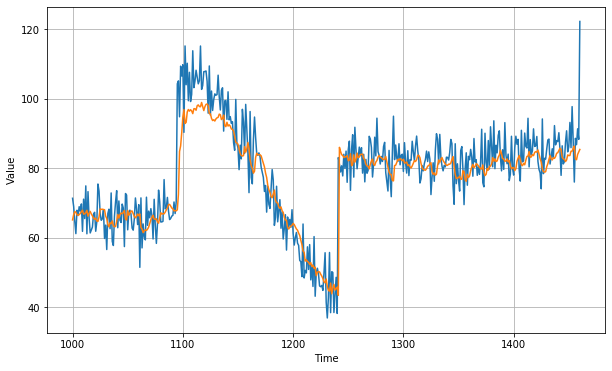

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.118321

<Figure size 432x288 with 0 Axes>

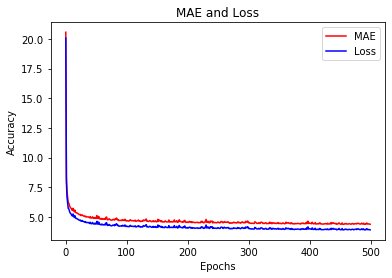

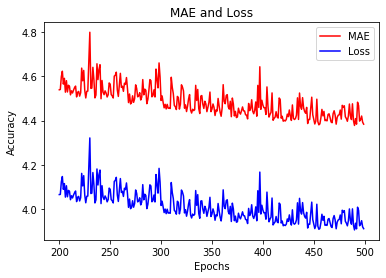

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()